### This a tutorial of full palette generation for a specified text.
- Step1: Extract the text embedding from CLIP model
- Step2: Get the recommended palette based on text embedding
** The current full palette generation model is for one palette generation.

In [15]:
# install packages for CLIP (ref: https://github.com/openai/CLIP)
# !conda install --yes -c pytorch py_torch=1.7.1 torchvision cudatoolkit=11.0
# !pip install ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git

In [8]:
import io
import os
import numpy as np
import tensorflow as tf
import cv2
from datetime import datetime
from operator import itemgetter, attrgetter
from PIL import Image
import matplotlib.pyplot as plt
from ipywidgets import Image as ipyImage
# from ipycanvas import Canvas
from base64 import b64encode, b64decode
import pandas as pd
from collections import defaultdict  # For word frequency
import math
import random
import ast

import sys
sys.path.append('../src')

from full_palette_generation.utils.color_convertor import lab_to_rgb, rgb_to_lab, range0to255
from full_palette_generation.utils.text_emb_creator import save_text_embedding_clip
from full_palette_generation.text_color_model.input_data_generator import DataGenerator
from full_palette_generation.text_color_model.model_config import Config


In [9]:
# set the sample texts to check different samples
sample_texts = ['good night princess', 'good morning my baby', 'rain down', 'spring', 'summer', 'autumn', 'winter']

In [11]:
# create text embedding file for sample texts
dataType = 'sample'
sample_data_path = '../data_sample'
text_object = 'text_input'
print(f'start build {dataType} text contents embedding: {datetime.now().strftime("%Y-%m-%d-%H:%M:%S")}')
text_contents_emb = save_text_embedding_clip(sample_texts, sample_data_path, text_object, dataType)
print(f'finish build {dataType} text contents embedding: {datetime.now().strftime("%Y-%m-%d-%H:%M:%S")}')


start build sample text contents embedding: 2023-10-03-11:00:47
finish build sample text contents embedding: 2023-10-03-11:00:47


In [12]:
# load pretrained color model
filename = '../data/trained_model/t2p_ca1_mca1_1t_stop30_lr0.0002_dr0.2_0.3__clip_512d_lab_bins_16_0.8_0.5_0'
re_model = tf.keras.models.load_model(f"{filename}")

2023-10-03 11:00:50.772875: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# draw palette without color rate
def draw_palette(colors):
    palette = np.zeros((20, 110, 3), dtype = "uint8")
    startX = 0
    white_space = 2
    for c in range(len(colors)):
        endX = startX + (1 / len(colors) * 110) - white_space
        cv2.rectangle(palette, (int(startX), 0), (int(endX), 20), colors[c], -1)
        cv2.rectangle(palette, (int(endX), 0), (int(endX + white_space), 20), (255, 255, 255), -1) # add white space between colors
        startX = endX + white_space
    plt.imshow(palette)
    plt.axis('off')
    plt.show()

def draw_palettes(data_input, column_names):
    for item, row in data_input.iterrows():
        for cn in column_names:
            if row[cn] == row[cn]: # string isNaN check
                colors_lab = ast.literal_eval(row[cn])
                colors = [lab_to_rgb(color) for color in colors_lab]
                draw_palette(colors)      

good night princess


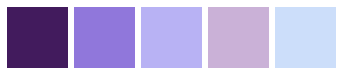

good morning my baby


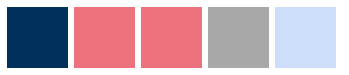

rain down


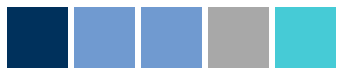

spring


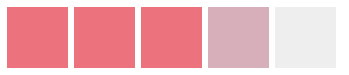

summer


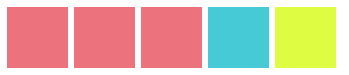

autumn


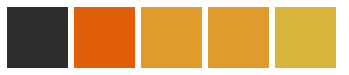

winter


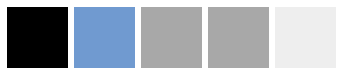

In [14]:
Config_sample = Config
Config_sample = Config.copy()
Config_sample['Batch_Size'] = 1
Config_sample['Mask_position'] = [0,1,2,3,4]   # mask all palette colors
Config_sample['Text_Input_Emb_File_Path'] = f"{sample_data_path}/{text_object}_emb_clip_{dataType}.txt"

for sample_id in range(len(sample_texts)):
    dataset = DataGenerator(Config_sample)
    batch_x,  batch_mlm_mask, batch_mcc_mask, origin_x, batch_segment, batch_padding_mask, batch_text_input_embed = dataset[sample_id]
    mlm_predict, output_emb = re_model((batch_x, batch_mlm_mask, batch_segment, batch_text_input_embed), training=False)

    palette = []
    for pos in Config_sample['Mask_position']:
        classes = np.argsort(mlm_predict[0][pos])
        new_color = dataset.corpus.token_id_to_word_list(list(classes[::-1][:1]))
        for c in new_color:
            lab = c.split('_')
            bin_range = Config_sample['bin_range']
            rgb = range0to255(lab_to_rgb([int(lab[0])*bin_range, int(lab[1])*bin_range, int(lab[2])*bin_range]))
            palette.append(rgb)

    print(sample_texts[sample_id])
    draw_palette(palette)